# Laboratorio 7

Más ejemplos de redes convolucionales

## 1. Librerías

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114250 sha256=d2d33c3858c0f97bf1a85765fc829f5bde709a2fd41c97a9a8bcfc5596b4fc34
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import requests
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

from medmnist import PneumoniaMNIST

## 2. Cargar datos

In [3]:
# Imagenes de cifar100
val_dataset = PneumoniaMNIST(split="val", download=True)
train_dataset = PneumoniaMNIST(split="train", download=True)
test_dataset = PneumoniaMNIST(split="test", download=True)



# PROBLEMA BINARIO

100%|██████████| 4170669/4170669 [00:00<00:00, 31386344.69it/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [4]:
val_dataset, train_dataset, test_dataset

(Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
     Number of datapoints: 524
     Root location: /root/.medmnist
     Split: val
     Task: binary-class
     Number of channels: 1
     Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
     Number of samples: {'train': 4708, 'val': 524, 'test': 624}
     Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
     License: CC BY 4.0,
 Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
     Number of datapoints: 4708
     Root location: /root/.medmnist
     Split: train
     Task: binary-class
     Number of channels: 1
     Meaning of labels: {'0': 'n

## 3. Pre-procesamiento

- Normalizar las imagenes
- Cambiarlas de tamaño
- Añadir aumento de datos

In [5]:
# Convert data to numpy arrays for Keras compatibility
X_train = np.expand_dims(train_dataset.imgs, axis=-1)
y_train = train_dataset.labels

X_val = np.expand_dims(val_dataset.imgs, axis=-1)
y_val = val_dataset.labels

X_test = np.expand_dims(test_dataset.imgs, axis=-1)
y_test = test_dataset.labels

# Step 2: Normalize the data
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [6]:
X_train.shape, y_train.shape

((4708, 28, 28, 1), (4708, 1))

Cuantas hay por clase?

In [8]:
print(y_train.sum()/y_train.shape[0])

# Obtener pesos por categoria
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train.flatten())
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights)

0.7421410365335599
{0: 1.9390444810543657, 1: 0.6737263880938752}


Mostrar algunas de las imagenes con sus respectivas etiquetas

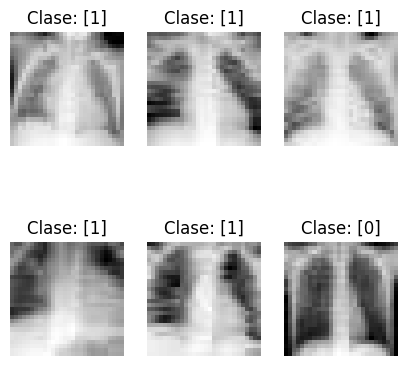

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(5, 5))
ax = ax.ravel()
for i in range(6):
  ax[i].imshow(X_train[i], cmap='gray')
  ax[i].set_title(f"Clase: {y_train[i]}")
  ax[i].axis("off")

plt.show()

Añadimos imagenes generadas - esta vez las añadiremos como capa

In [11]:
data_augmentation = keras.models.Sequential([
    layers.Resizing(64, 64),  # Resize to 64x64
    layers.RandomFlip('horizontal'),  # Randomly flip images horizontally
    layers.RandomRotation(0.2),  # Random rotation by 20%
    layers.RandomZoom(0.2),  # Random zoom by 20%
])

## 4. Arquitectura del modelo y entrenamiento

Usaremos 2 bloques completos de convoluciones + una capa convolucional seguida por una densa y la de clasificación de salida.

En convoluciones, por defecto tenemos:
* Paso: strides=(1, 1), es decir 1 pixel a la vez
* Relleno: padding="valid", que es lo mismo a no padding/relleno

In [13]:
model = keras.models.Sequential([
    data_augmentation,  # Add the data augmentation layer at the start
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # New input shape 64x64
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])
model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682,753 (2.60 MB)

 Trainable params: 682,753 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
# Custom metrics for Sensitivity and Specificity
def sensitivity(y_true, y_pred):
    """ Sensitivity = True Positives / (True Positives + False Negatives) """
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    """ Specificity = True Negatives / (True Negatives + False Positives) """
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())



# Initialize the Adam optimizer with a learning rate of 0.005
optimizer = Adam(learning_rate=0.005)

# Compile the model with the Adam optimizer
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy',  sensitivity, specificity])


history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), class_weight=class_weights, shuffle=True)


Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 657ms/step - accuracy: 0.5352 - loss: 0.8479 - sensitivity: 0.5724 - specificity: 0.4336 - val_accuracy: 0.4828 - val_loss: 0.7121 - val_sensitivity: 0.3186 - val_specificity: 0.9471
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 67s 458ms/step - accuracy: 0.6982 - loss: 0.5886 - sensitivity: 0.7118 - specificity: 0.6560 - val_accuracy: 0.9027 - val_loss: 0.3160 - val_sensitivity: 0.8912 - val_specificity: 0.9438
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.8280 - loss: 0.3728 - sensitivity: 0.8213 - specificity: 0.8379 - val_accuracy: 0.7595 - val_loss: 0.5017 - val_sensitivity: 0.6655 - val_specificity: 0.9853
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 435ms/step - accuracy: 0.8488 - loss: 0.3416 - sensitivity: 0.8444 - specificity: 0.8626 - val_accuracy: 0.9008 - val_loss: 0.2330 - val_sensitivity: 0.9006 - val_specificity: 0.9062
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 442ms/step - accuracy: 0.8649 - loss: 0.3250 - sensitivity

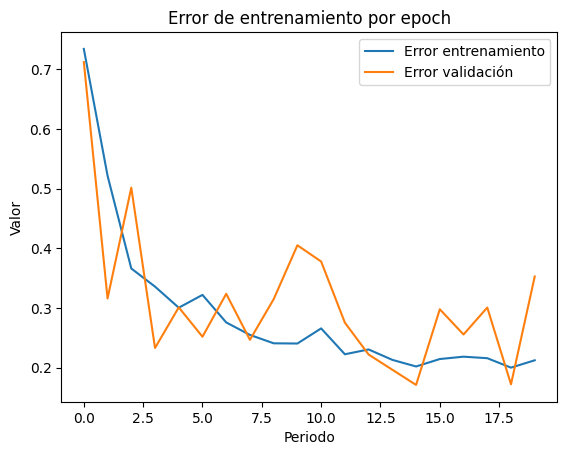

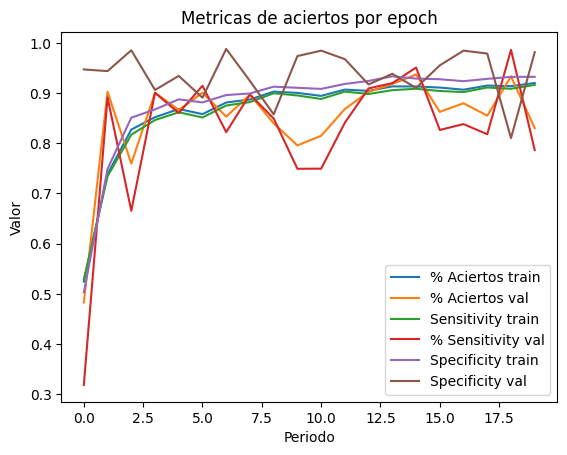

In [ ]:
# Ver resultados en entrenamiento y validación
plt.plot(history.history["loss"], label="Error entrenamiento")
plt.plot(history.history["val_loss"], label="Error validación")
plt.title("Error de entrenamiento por epoch")
plt.xlabel("Periodo")
plt.ylabel("Valor")
plt.legend()
plt.show()

# De métricas de precisión
plt.plot(history.history["accuracy"], label="% Aciertos train")
plt.plot(history.history["val_accuracy"], label="% Aciertos val")
plt.plot(history.history["sensitivity"], label="Sensitivity train")
plt.plot(history.history["val_sensitivity"], label="% Sensitivity val")
plt.plot(history.history["specificity"], label="Specificity train")
plt.plot(history.history["val_specificity"], label="Specificity val")
plt.title("Metricas de aciertos por epoch")
plt.xlabel("Periodo")
plt.ylabel("Valor")
plt.legend()
plt.show()

## 5. Valoración del rendimiento en el set de testeo

In [ ]:
# Obteniendo accuracy general
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test sensitivity:", score[2])
print("Test specificity:", score[3])

Test loss: 0.31554457545280457
Test accuracy: 0.8653846383094788
Test sensitivity: 0.8286741375923157
Test specificity: 0.902405858039856


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


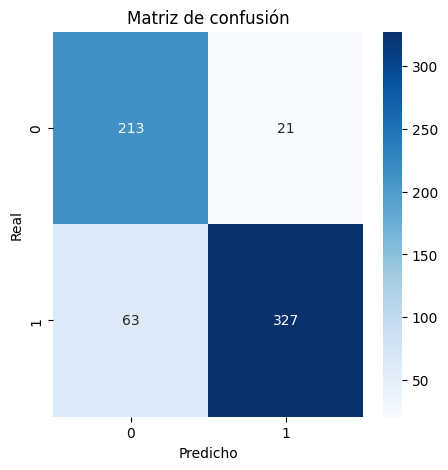

In [ ]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Create confusion matrix
predichos = np.where(model.predict(X_test) > 0.5, 1, 0)
conf_matrix = confusion_matrix(y_test, predichos)

# Plot confusion matrix using seaborn
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()

Interpretabilidad

In [ ]:
!pip install shap

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:42, 42.32s/it]               

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


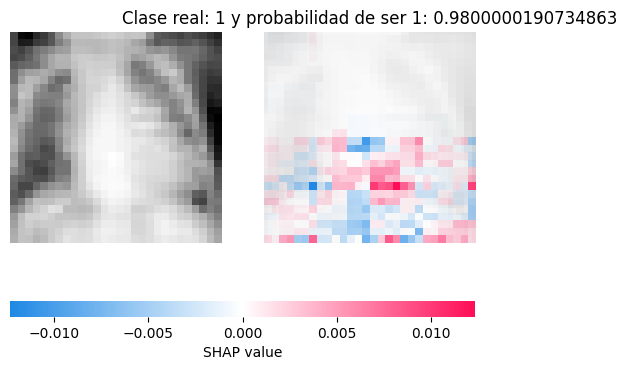

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.43s/it]               

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


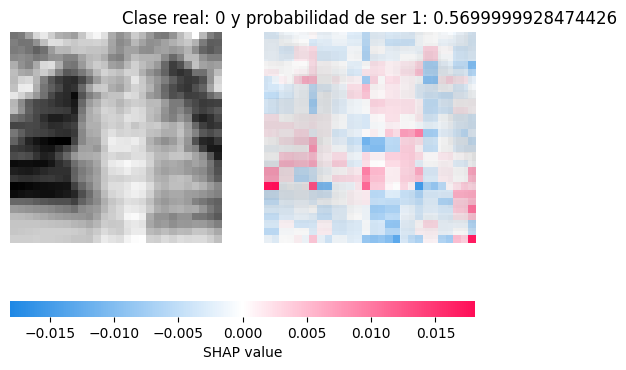

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.58s/it]               

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


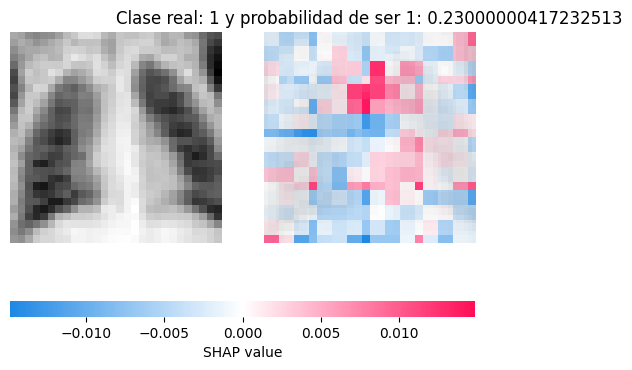

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.59s/it]               


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


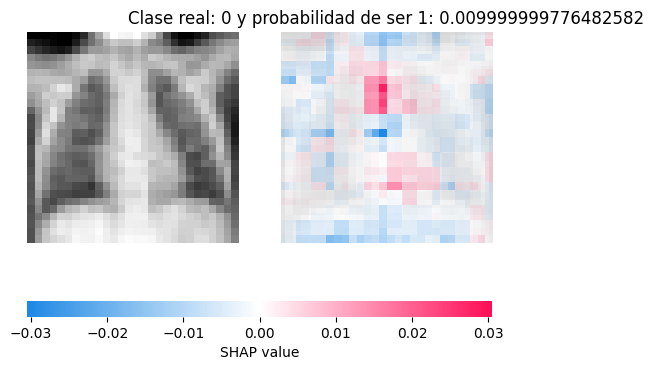

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.42s/it]               

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


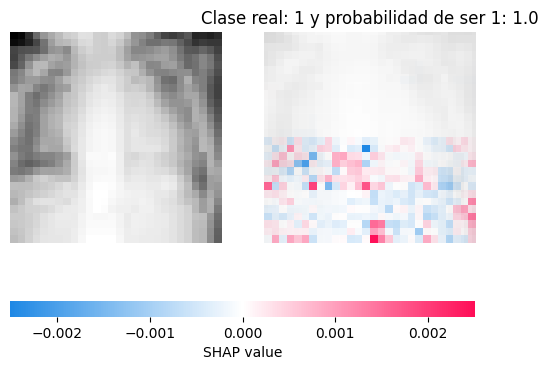

In [ ]:
import shap
# Step 1: Select a subset of images for SHAP explanation (for example, from the test set)
def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(32,32)", X_test[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=["PNEUMONIA"])
for ind in range(5):
  shap_values_ = explainer(X_test[[ind]], max_evals=5000, batch_size=50)
  p = shap.image_plot(shap_values_,labels=["PNEUMONIA"], show=False)
  plt.title(f"Clase real: {y_test[[ind]][0][0]} y probabilidad de ser 1: {np.round(model.predict(X_test[[ind]])[0][0],2)}")
  plt.show()